<a href="https://colab.research.google.com/github/jiheeko/Seperation-of-waste-by-materials/blob/main/jsontomask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json

In [3]:
with open('/content/drive/MyDrive/dataset/train/_annotations.coco.json','r') as file:
  data = json.load(file)

In [4]:
for img in data['images']:
  print(img['file_name'])

glass110_jpg.rf.f0074b9238f82f4afa627f5e1246e627.jpg
plastic306_jpg.rf.f6d257e2d7547620ca4199bb05a30847.jpg
glass116_jpg.rf.efce2e406f81a3dccf34c015f3419b2f.jpg
-1_jpg.rf.efdd4aabab0ab35bef836aeb509c1520.jpg
paper268_jpg.rf.f0257b136bde77d5371b39c2f35fa491.jpg
glass118_jpg.rf.f3443260ee2828a46138835120abb51f.jpg
plastic179_jpg.rf.f1c6b674628eb44a0588e5ab7062c1b2.jpg
plastic312_jpg.rf.f0b48ba8b427fc07a2e8e92dc992dcba.jpg
-1_jpg.rf.f23812510eae09f2e1f57e41f574ff52.jpg
plastic138_jpg.rf.f8a513f4f29ec91ed4fe7da8d894c6e0.jpg
-2_png.rf.eff307267a8a41e83fbf8b5fe270d8e5.jpg
metal211_jpg.rf.fadd3ad6e8b404c8074028e86a173310.jpg
-3_jpg.rf.ef5631ea27a537bd8f25c33d344c3b34.jpg
glass160_jpg.rf.f5f6186b2daecd5607405720609a7749.jpg
glass1_jpg.rf.f4d9ea5384ee1a853417fc1ea9c56db0.jpg
plastic14_jpg.rf.f9041d5ddbcf7d92e3363c51fef57525.jpg
plastic193_jpg.rf.f0d3db5eeb13481e356acdf5a13592b7.jpg
-7_png.rf.fa117a56e2c3d0f7ecd9b5c366a5e17a.jpg
metal228_jpg.rf.f219736edd184f5c80e9bb989812fd55.jpg
glass104_jpg.r

In [5]:
import json

def print_structure(d,indent=0):
  if isinstance(d,dict):
    for k,v in d.items():
      print('  '*indent,k)
      print_structure(v,indent+1)
  elif isinstance(d,list):
    print(''*indent + "[List of length {} containing:]".format(len(d)))
    if d:
      print_structure(d[0],indent+1)

with open('/content/drive/MyDrive/dataset/train/_annotations.coco.json','r') as file:
  data = json.load(file)
  print_structure(data)

 info
   year
   version
   description
   contributor
   url
   date_created
 licenses
[List of length 1 containing:]
     id
     url
     name
 categories
[List of length 8 containing:]
     id
     name
     supercategory
 images
[List of length 471 containing:]
     id
     license
     file_name
     height
     width
     date_captured
 annotations
[List of length 858 containing:]
     id
     image_id
     category_id
     bbox
[List of length 4 containing:]
     area
     segmentation
[List of length 1 containing:]
[List of length 352 containing:]
     iscrowd


In [6]:
import os
import random
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [7]:
def display_images_with_coco_annotations(image_paths, annotations, display_type='both', colors=None):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Define a default color map if none is provided
        if colors is None:
            colors = plt.cm.get_cmap('tab10')

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        for ann in img_annotations:
            category_id = ann['category_id']
            color = colors(category_id % 10)

            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color, fill=False)
                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()


<ipython-input-7-af55ad53f505>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


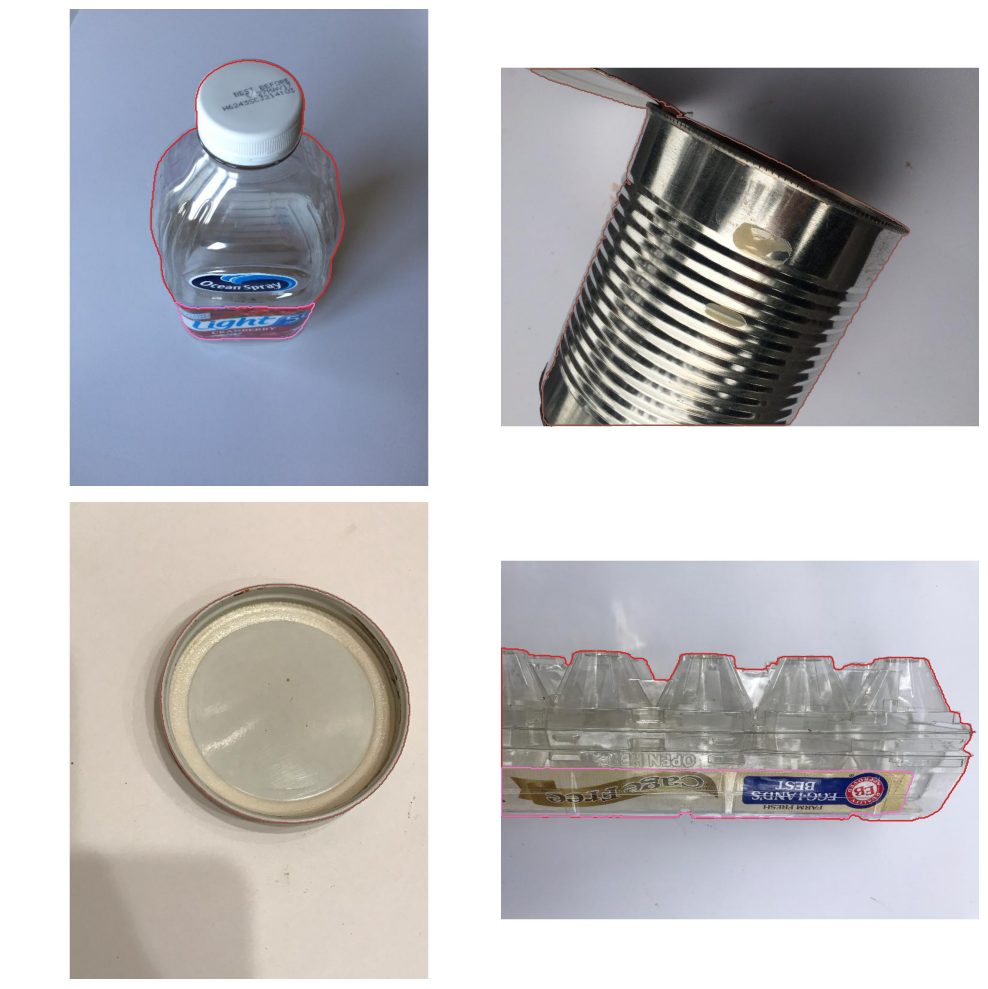

In [8]:
with open('/content/drive/MyDrive/dataset/train/_annotations.coco.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "/content/drive/MyDrive/dataset/train"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type)



#display_images_with_coco_annotations(['livecell_test_images/SKOV3_Phase_F4_2_03d00h00m_4.tif'], annotations, display_type)

In [9]:
import json
import numpy as np
import skimage
import tifffile
import os
import shutil

In [10]:

def create_mask(image_info, annotations, output_folder):
    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width'], 3), dtype=np.uint8)

    # Counter for the object number
    object_number = 1

    for ann in annotations:
        if ann['image_id'] == image_info['id']:
            # Extract segmentation polygon
            for seg in ann['segmentation']:
                # Convert polygons to a binary mask and add it to the main mask
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                mask_np[rr, cc, :] = object_number * 10  # Adjust color for each object
                object_number += 1  # We are assigning each object a unique integer value (labeled mask)

    # Save the numpy array as a TIFF using tifffile library
    mask_path = os.path.join(output_folder, image_info['file_name'].replace('.tif', '_mask.tif'))
    tifffile.imsave(mask_path, mask_np)

    print(f"Saved mask for {image_info['file_name']} to {mask_path}")

# Example Usage:
# main("your_json_file.json", "your_mask_output_folder", "your_image_output_folder", "your_original_image_dir")


In [11]:
def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    # Load COCO JSON annotations
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)

        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])

        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)
        print(f"Copied original image to {new_image_path}")

In [12]:
if __name__ == '__main__':
    original_image_dir = '/content/drive/MyDrive/dataset/train'  # Where your original images are stored
    json_file = '/content/drive/MyDrive/dataset/train/_annotations.coco.json'
    mask_output_folder = '/content/drive/MyDrive/dataset/trainmasks'  # Modify this as needed. Using val2 so my data is not overwritten
    image_output_folder = '/content/drive/MyDrive/dataset/trainimages'  #
    main(json_file, mask_output_folder, image_output_folder, original_image_dir)


<ipython-input-10-bf7413d84b81>:19: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(mask_path, mask_np)


Saved mask for glass110_jpg.rf.f0074b9238f82f4afa627f5e1246e627.jpg to /content/drive/MyDrive/dataset/trainmasks/glass110_jpg.rf.f0074b9238f82f4afa627f5e1246e627.jpg
Copied original image to /content/drive/MyDrive/dataset/trainimages/glass110_jpg.rf.f0074b9238f82f4afa627f5e1246e627.jpg
Saved mask for plastic306_jpg.rf.f6d257e2d7547620ca4199bb05a30847.jpg to /content/drive/MyDrive/dataset/trainmasks/plastic306_jpg.rf.f6d257e2d7547620ca4199bb05a30847.jpg
Copied original image to /content/drive/MyDrive/dataset/trainimages/plastic306_jpg.rf.f6d257e2d7547620ca4199bb05a30847.jpg
Saved mask for glass116_jpg.rf.efce2e406f81a3dccf34c015f3419b2f.jpg to /content/drive/MyDrive/dataset/trainmasks/glass116_jpg.rf.efce2e406f81a3dccf34c015f3419b2f.jpg
Copied original image to /content/drive/MyDrive/dataset/trainimages/glass116_jpg.rf.efce2e406f81a3dccf34c015f3419b2f.jpg
Saved mask for -1_jpg.rf.efdd4aabab0ab35bef836aeb509c1520.jpg to /content/drive/MyDrive/dataset/trainmasks/-1_jpg.rf.efdd4aabab0ab35b

In [13]:
if __name__ == '__main__':
    original_image_dir = '/content/drive/MyDrive/dataset/test'  # Where your original images are stored
    json_file = '/content/drive/MyDrive/dataset/test/_annotations.coco.json'
    mask_output_folder = '/content/drive/MyDrive/dataset/testmasks'  # Modify this as needed. Using val2 so my data is not overwritten
    image_output_folder = '/content/drive/MyDrive/dataset/testimages'  #
    main(json_file, mask_output_folder, image_output_folder, original_image_dir)

<ipython-input-10-bf7413d84b81>:19: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(mask_path, mask_np)


Saved mask for glass15_jpg.rf.43ac8a6ac5556acbe64d33f57b00a6dc.jpg to /content/drive/MyDrive/dataset/testmasks/glass15_jpg.rf.43ac8a6ac5556acbe64d33f57b00a6dc.jpg
Copied original image to /content/drive/MyDrive/dataset/testimages/glass15_jpg.rf.43ac8a6ac5556acbe64d33f57b00a6dc.jpg
Saved mask for glass170_jpg.rf.265ae61e556ae027343e29d1abfc53c1.jpg to /content/drive/MyDrive/dataset/testmasks/glass170_jpg.rf.265ae61e556ae027343e29d1abfc53c1.jpg
Copied original image to /content/drive/MyDrive/dataset/testimages/glass170_jpg.rf.265ae61e556ae027343e29d1abfc53c1.jpg
Saved mask for glass18_jpg.rf.02c70d42c62e24e7fb510a35625c940b.jpg to /content/drive/MyDrive/dataset/testmasks/glass18_jpg.rf.02c70d42c62e24e7fb510a35625c940b.jpg
Copied original image to /content/drive/MyDrive/dataset/testimages/glass18_jpg.rf.02c70d42c62e24e7fb510a35625c940b.jpg
Saved mask for glass158_jpg.rf.0b91178c701bee84db894f1788969153.jpg to /content/drive/MyDrive/dataset/testmasks/glass158_jpg.rf.0b91178c701bee84db894f1

In [14]:
if __name__ == '__main__':
    original_image_dir = '/content/drive/MyDrive/dataset/valid'  # Where your original images are stored
    json_file = '/content/drive/MyDrive/dataset/valid/_annotations.coco.json'
    mask_output_folder = '/content/drive/MyDrive/dataset/validmasks'  # Modify this as needed. Using val2 so my data is not overwritten
    image_output_folder = '/content/drive/MyDrive/dataset/validimages'  #
    main(json_file, mask_output_folder, image_output_folder, original_image_dir)

<ipython-input-10-bf7413d84b81>:19: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(mask_path, mask_np)


Saved mask for cardboard164_jpg.rf.002ac1791c9e8b90e5c32f8d055d61d6.jpg to /content/drive/MyDrive/dataset/validmasks/cardboard164_jpg.rf.002ac1791c9e8b90e5c32f8d055d61d6.jpg
Copied original image to /content/drive/MyDrive/dataset/validimages/cardboard164_jpg.rf.002ac1791c9e8b90e5c32f8d055d61d6.jpg
Saved mask for cardboard137_jpg.rf.02120f24c2b24baf91c9c162abfd44e7.jpg to /content/drive/MyDrive/dataset/validmasks/cardboard137_jpg.rf.02120f24c2b24baf91c9c162abfd44e7.jpg
Copied original image to /content/drive/MyDrive/dataset/validimages/cardboard137_jpg.rf.02120f24c2b24baf91c9c162abfd44e7.jpg
Saved mask for cardboard146_jpg.rf.0259aab7515629c7719848bb2e6b8302.jpg to /content/drive/MyDrive/dataset/validmasks/cardboard146_jpg.rf.0259aab7515629c7719848bb2e6b8302.jpg
Copied original image to /content/drive/MyDrive/dataset/validimages/cardboard146_jpg.rf.0259aab7515629c7719848bb2e6b8302.jpg
Saved mask for cardboard159_jpg.rf.03d00207759f82da6a7d4ffc2960b1ab.jpg to /content/drive/MyDrive/datas